### 숫자예측 모델(LSTM)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# 1. 데이터 생성 (랜덤 숫자 시퀀스)
data = np.array([i for i in range(1, 21)])  # 1부터 20까지의 숫자
timesteps = 3  # 타임스텝 길이, sequence lenght와 같은 개념

In [ ]:
x_data = []
y_data = []

In [ ]:
# 타임스텝에 따라 입력 데이터와 출력 데이터 생성
for i in range(len(data) - timesteps):
    x_data.append(data[i:i + timesteps])  # 입력 (3개의 숫자)
    y_data.append(data[i + timesteps])   # 출력 (다음 숫자)

x_data = np.array(x_data).reshape(-1, timesteps, 1)  # (샘플 수, 타임스텝, 피처 수)
y_data = np.array(y_data)  # 출력값

In [ ]:
# 2. LSTM 모델 정의
model = Sequential([
    LSTM(10, input_shape=(timesteps, 1)),  # LSTM 레이어 (유닛: 10)
    Dense(1)  # 출력 레이어
])

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
# 3. 모델 학습
model.fit(x_data, y_data, epochs=1000, verbose=1)  # 100번 반복 학습

In [ ]:
# 4. 예측 테스트
test_input = np.array([18, 19, 20]).reshape(1, timesteps, 1)  # 입력 예시
predicted_value = model.predict(test_input)

In [ ]:
# 결과 출력
print("입력 데이터:", test_input.flatten()) # flatten함수 : [[1,2],[3,4]] --> [1,2,3,4]
print("예측 값:", predicted_value[0][0])

### 기온예측 모델(RNN)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [ ]:
# 1. 데이터 로드
file_path = "dataset/jena_climate_2009.csv"
data = pd.read_csv(file_path)

In [ ]:
# 데이터 확인
# Date Time: 관측 날짜 및 시간. p (mbar): 기압. T (degC): 기온, Tpot (K): 잠재온도
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
data.shape

(10676, 15)

In [ ]:
# T (degC) : 기온
temperature = data['T (degC)'].values

In [ ]:
# 2. 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))  # 정규화
scaled_data = scaler.fit_transform(temperature.reshape(-1, 1))

In [ ]:
# 데이터셋 생성 함수 : look_back(sequence length와 같은 의미)
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [ ]:
look_back = 60  # 과거 60분 데이터를 기반으로 예측
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # RNN 입력 형태

In [ ]:
X.shape

(2204, 60, 1)

In [ ]:
# 데이터 분리
train_size = int(len(X) * 0.8)  # 80% 학습 데이터
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# 3. RNN 모델 구성
model = Sequential([
    SimpleRNN(50, return_sequences=False, input_shape=(X.shape[1], 1)),  # 50(뉴런 즉 메모리유닛수), return_sequence=False(마지막시점 출력만 반환)
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 4. 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.5903e-05 - val_loss: 7.1297e-05
Epoch 2/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 4.4628e-05 - val_loss: 4.8985e-05
Epoch 3/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.5806e-05 - val_loss: 6.6042e-05
Epoch 4/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.1052e-05 - val_loss: 2.6718e-05
Epoch 5/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.8763e-05 - val_loss: 7.6757e-05
Epoch 6/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 4.4063e-05 - val_loss: 2.9395e-05
Epoch 7/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.2775e-05 - val_loss: 2.5490e-05
Epoch 8/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.5481e-05 - val_loss: 4.4458e-05
Epoch 9/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 3.3595e-05 - val_loss: 5.3731e-05
Epoch 10/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 3.5761e-05 - val_loss: 2.2608e-05
Epoch 11/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/

In [ ]:
# 5. 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # 정규화 복원

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
# 실제 값 복원
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

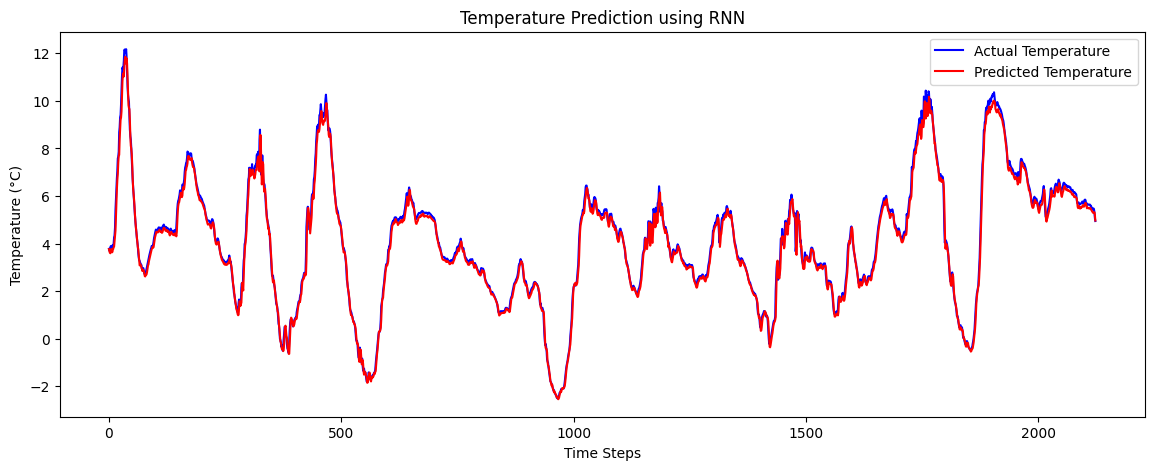

In [ ]:
# 6. 시각화
plt.figure(figsize=(14, 5))
plt.plot(actual_values, label="Actual Temperature", color='blue')
plt.plot(predictions, label="Predicted Temperature", color='red')
plt.title('Temperature Prediction using RNN')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

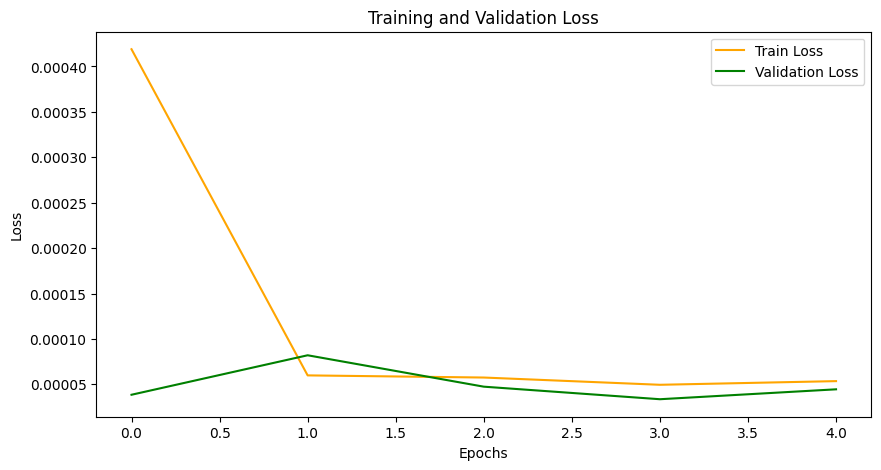

In [ ]:
# 7. 학습 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 주가예측 모델(LSTM)

In [ ]:
# 증권데이터 수집 라이브러리 설치 :  pip install yfinance
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# 1. 데이터 수집
ticker = "AAPL"  # 예: 애플 주식
data = yf.download(ticker, start="2015-01-01", end="2024-01-01")
data = data[['Close']]  # 종가만 사용

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head()

Price,Close
Ticker,AAPL
Date,
2015-01-02,24.320435
2015-01-05,23.635283
2015-01-06,23.637506
2015-01-07,23.968964
2015-01-08,24.889896


In [ ]:
# 2. 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [ ]:
look_back = 60  # 과거 60일 데이터로 예측
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # LSTM 입력 형태 (샘플수, 시퀀스 길이, 피처수)

In [ ]:
# 3. 모델 구성
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),  # input_shape(시퀀스 길이, 피처수)
    LSTM(50),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 4. 모델 학습
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

In [ ]:
# 5. 예측 및 시각화
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))  # 2차원 배열로 표시 (샘플수, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


In [ ]:
# 실제 값 복원
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

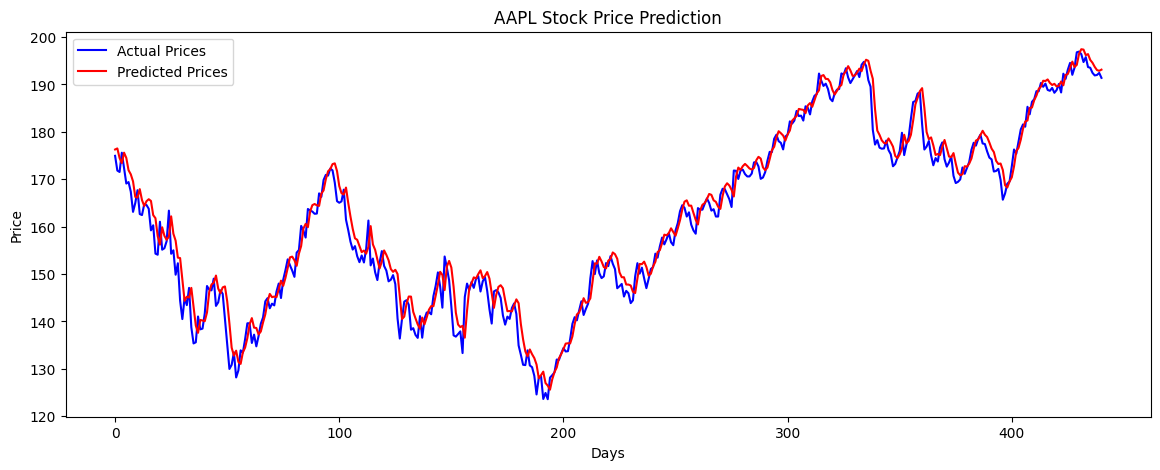

In [ ]:
# 시각화
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='red')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

### 주가예측 모델(GRU)

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

In [ ]:
# 1. 데이터 수집
ticker = "AAPL"  # 애플 주식
data = yf.download(ticker, start="2015-01-01", end="2024-01-01")
data = data[['Close']]  # 종가 데이터만 사용

[*********************100%***********************]  1 of 1 completed


In [ ]:
# 2. 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))  # 데이터를 0~1 사이로 정규화
scaled_data = scaler.fit_transform(data)

In [ ]:
# GRU 모델에 적합한 데이터셋 생성 함수
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [ ]:
look_back = 60  # 과거 60일 데이터로 예측
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # GRU 입력 형태

In [ ]:
# 3. GRU 모델 구성
model = Sequential([
    GRU(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    GRU(50),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 4. 모델 학습
train_size = int(len(X) * 0.8)  # 80% 학습 데이터, 20% 테스트 데이터
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.0408 - val_loss: 7.2451e-04
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 2.5217e-04 - val_loss: 5.3749e-04
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 1.4906e-04 - val_loss: 5.6741e-04
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 1.6695e-04 - val_loss: 4.6104e-04
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 1.4854e-04 - val_loss: 5.0091e-04
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 1.6029e-04 - val_loss: 4.1404e-04
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 1.2185e-04 - val_loss: 5.2404e-04
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 1.4006e-04 - val_loss: 3.7142e-04
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 1.1489e-04 - val_loss: 4.8070e-04
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 1.2394e-04 - val_loss: 4.1188e-04
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 1.0895e-04 

In [ ]:
# 5. 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))  # 정규화 복원

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [ ]:
# 실제 값 복원
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

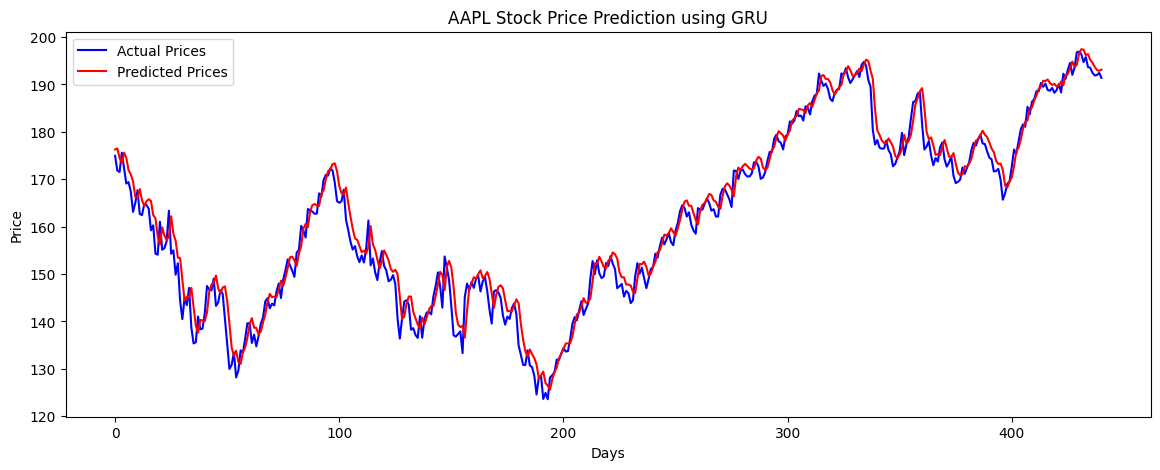

In [ ]:
# 6. 시각화
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='red')
plt.title(f'{ticker} Stock Price Prediction using GRU')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

### 항공기 탑승객 수요 예측(LSTM)

In [ ]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# 데이터 불러오기
data_path = 'dataset/airline.csv'  # 데이터 경로
df = pd.read_csv(data_path)

In [ ]:
# 데이터 확인
print(df.head())

         date  count
0  1949-01-01    112
1  1949-02-01    118
2  1949-03-01    132
3  1949-04-01    129
4  1949-05-01    121


In [ ]:
# 날짜(Date)와 탑승객 수(count) 열의 이름 설정 및 변환
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

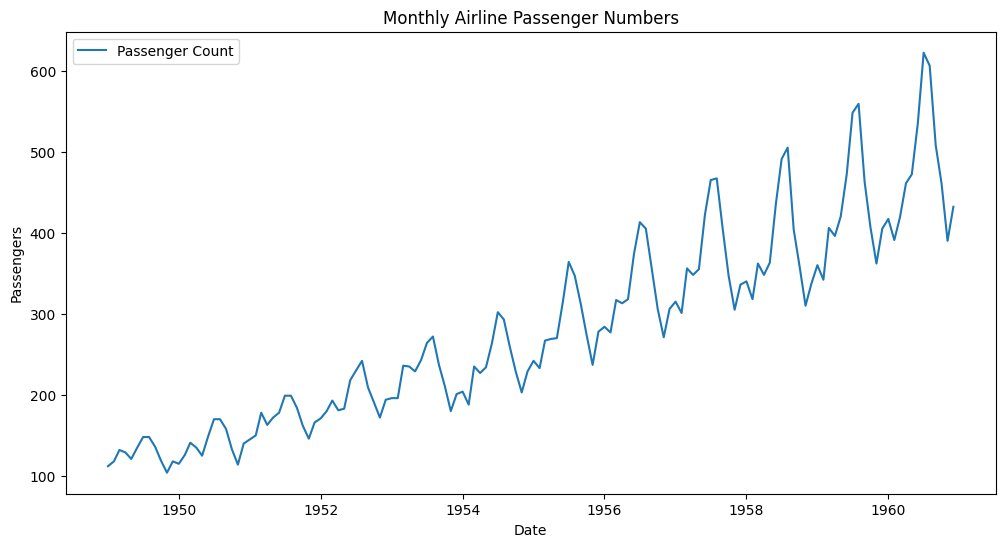

In [ ]:
# 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(df['count'], label='Passenger Count')
plt.title('Monthly Airline Passenger Numbers')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

In [ ]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['count']])

In [ ]:
# 데이터셋 분리 (학습 데이터와 테스트 데이터)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [ ]:
# 시계열 데이터셋 생성 함수
def create_dataset(data, time_step=12):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(data[i+time_step])
    return np.array(X), np.array(y)

In [ ]:
time_step = 12  # 12개월 단위로 예측
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# LSTM 입력에 맞게 데이터 형태 변경
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# LSTM 모델 생성
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1, shuffle=False)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 325ms/step - loss: 0.1208 - val_loss: 0.3147
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0528 - val_loss: 0.0882
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0156 - val_loss: 0.0236
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0195 - val_loss: 0.0254
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0111 - val_loss: 0.0583
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0106 - val_loss: 0.0702
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0106 - val_loss: 0.0524
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0078 - val_loss: 0.0293
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0087 - val_loss: 0.0240
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0086 - val_loss: 0.0252
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0075 - val_loss: 0.0299
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0072 - val_loss: 0.0303


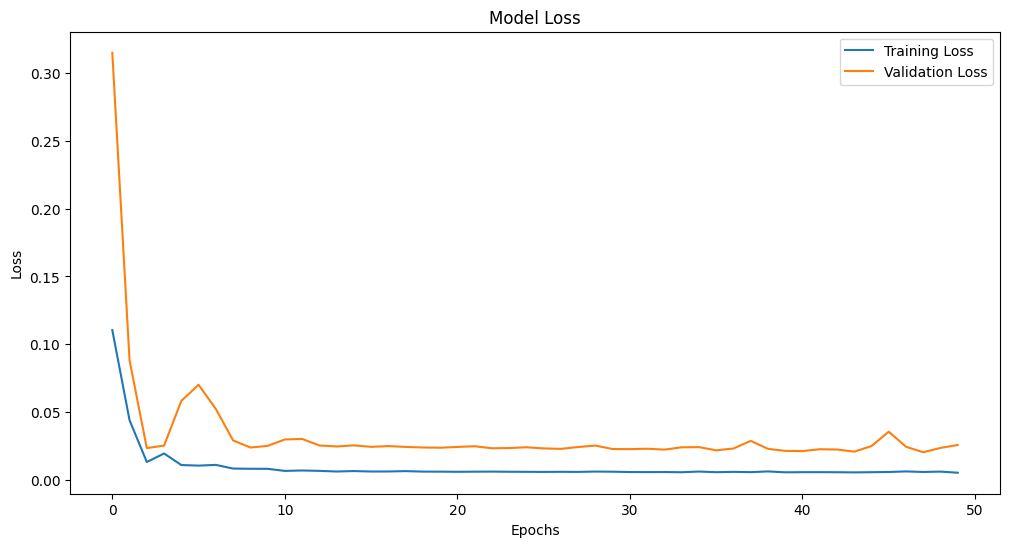

In [ ]:
# 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 테스트 데이터 예측
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [ ]:
# 예측값 역정규화
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

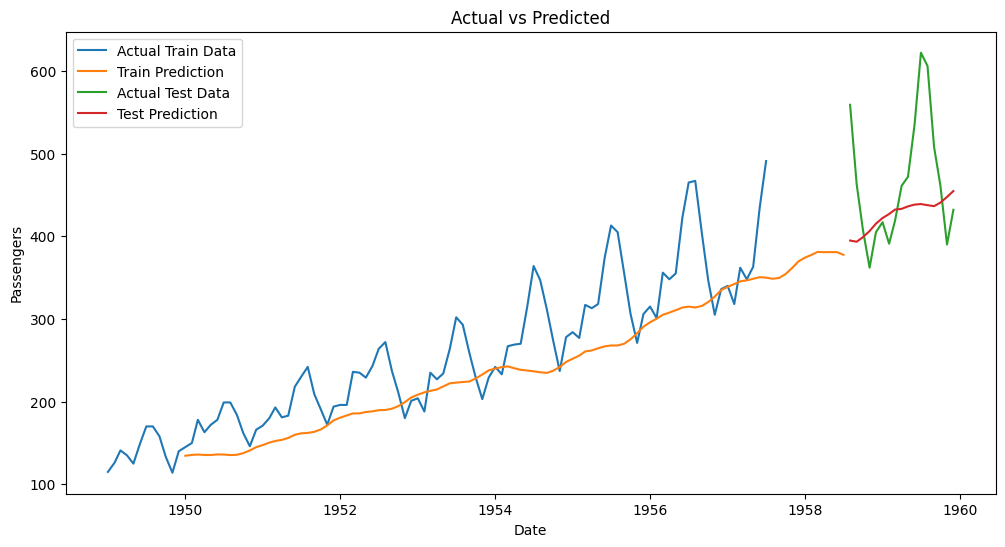

In [ ]:
# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index[:len(y_train)], y_train, label='Actual Train Data')
plt.plot(df.index[time_step:len(train_predict) + time_step], train_predict, label='Train Prediction')
plt.plot(df.index[len(train_data):len(train_data) + len(test_predict)], y_test, label='Actual Test Data')
plt.plot(df.index[len(train_data):len(train_data) + len(test_predict)], test_predict, label='Test Prediction')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

### 자전거 대여량 예측(GRU)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split

In [ ]:
# 1. 데이터 불러오기
dataset_path = './dataset/'
train_data = pd.read_csv(dataset_path + 'train.csv')
test_data = pd.read_csv(dataset_path + 'test.csv')

In [ ]:
# 2. 데이터 전처리
def preprocess_data(data):
    data['datetime'] = pd.to_datetime(data['datetime'])
    data['hour'] = data['datetime'].dt.hour
    data['day'] = data['datetime'].dt.day
    data['month'] = data['datetime'].dt.month
    data['year'] = data['datetime'].dt.year

    data = data.drop(['datetime', 'casual', 'registered'], axis=1, errors='ignore')
    return data

In [ ]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

In [ ]:
# Feature와 Target 분리
X = train_data.drop(['count'], axis=1).values
y = train_data['count'].values.reshape(-1, 1)

In [ ]:
# MinMaxScaler를 사용하여 데이터 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [ ]:
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

In [ ]:
# Train/Test 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 3. 데이터 차원 조정 (GRU 입력 형태로 변환)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [ ]:
# 4. GRU 모델 생성
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
# 5. 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    shuffle=False
)


Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0349 - val_loss: 0.0279
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0281 - val_loss: 0.0276
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0283 - val_loss: 0.0254
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0269 - val_loss: 0.0251
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0243 - val_loss: 0.0216
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0218 - val_loss: 0.0203
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0192 - val_loss: 0.0172
Epoch 8/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0181 - val_loss: 0.0159
Epoch 9/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0172 - val_loss: 0.0150
Epoch 10/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0160 - val_loss: 0.0139
Epoch 11/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0146 - val_loss: 0.0137
Epoch 12/50
273/273 ━━━━━━━━━━━━━━━━━━

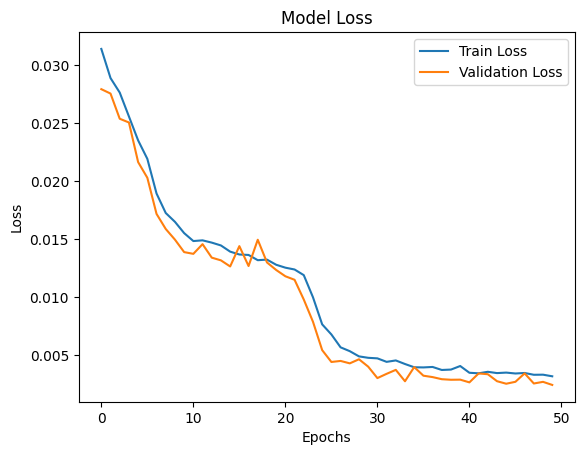

In [ ]:
# 6. 학습 과정 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# 7. 테스트 데이터 예측
X_test = scaler_X.transform(test_data.values)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)

203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
# 결과 저장
test_data['predicted_count'] = y_pred
test_data.to_csv(dataset_path + 'test_predictions.csv', index=False)
print("예측 결과가 'test_predictions.csv'로 저장되었습니다.")

예측 결과가 'test_predictions.csv'로 저장되었습니다.


### 타이타닉 생존자 예측 예제(LSTM)

In [ ]:
# 사전 라이브러리 설치(XAI용, XAI: 설명가능한 AI) : pip install shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer    # 결측치를 처리하는데 사용
from sklearn.preprocessing import LabelEncoder    #범주형 데이터를 숫자형 데이터로 변환하는 데 사용
import shap  # feature importance와 유사 (LSTM에 사용)

In [ ]:
# 1. 데이터 로드 및 전처리
train_df = pd.read_csv("dataset/train_titanic.csv")
test_df = pd.read_csv("dataset/test_titanic.csv")

In [ ]:
# 데이터 확인
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# 결측치 확인
print("Train 데이터 결측치 확인:")
print(train_df.isnull().sum())
print("\nTest 데이터 결측치 확인:")
print(test_df.isnull().sum())

Train 데이터 결측치 확인:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          688
Embarked         2
dtype: int64

Test 데이터 결측치 확인:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [ ]:
# 불필요한 컬럼 제거 (원핫 인코딩 없이도 잘 작동하도록)
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [ ]:
# Label Encoding (Sex 컬럼)
le = LabelEncoder()  # 범주형 문자열을 숫자형으로 변환
train_df['Sex'] = le.fit_transform(train_df['Sex'])
test_df['Sex'] = le.transform(test_df['Sex'])  # train 데이터 기준으로 transform
train_df.head()

In [ ]:
# Embarked 컬럼 처리 (최빈값으로 채우기)
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
test_df['Embarked'] = test_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

In [ ]:
# Label Encoding (Embarked 컬럼)
le_embarked = LabelEncoder()
train_df['Embarked'] = le_embarked.fit_transform(train_df['Embarked'])
test_df['Embarked'] = le_embarked.transform(test_df['Embarked']) # train 데이터 기준으로 transform

In [ ]:
# Age 컬럼 결측치 처리 (평균으로 채우기)
imputer = SimpleImputer(strategy='mean')
train_df['Age'] = imputer.fit_transform(train_df[['Age']])
test_df['Age'] = imputer.transform(test_df[['Age']])

# Fare 컬럼 결측치 처리 (평균으로 채우기)
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].mean()) # test 데이터에만 Fare 결측치 존재

In [ ]:
# 전처리 후 데이터 확인
print("전처리 후 데이터 형태:")
print("Train 데이터:", train_df.shape)
print("Test 데이터:", test_df.shape)

전처리 후 데이터 형태:
Train 데이터: (891, 8)
Test 데이터: (418, 7)


In [ ]:
# 데이터 컬럼 확인
print("\nTrain 데이터 컬럼:", train_df.columns.tolist())
print("Test 데이터 컬럼:", test_df.columns.tolist())


Train 데이터 컬럼: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Test 데이터 컬럼: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


In [ ]:
# 스케일링 (MinMaxScaler)
scaler = MinMaxScaler()
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

In [ ]:
# 피처 수 확인
n_features = X.shape[1]
print(f"피처 수: {n_features}")

피처 수: 7


In [ ]:
X = scaler.fit_transform(X)
test_data = scaler.transform(test_df)

In [ ]:
# 특성 이름 저장 (SHAP 시각화에 사용)
feature_names = train_df.drop('Survived', axis=1).columns.tolist()

In [ ]:
# train, validation set 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 데이터 형태 확인
print(f"X_train 형태(reshape 전): {X_train.shape}")
print(f"X_val 형태(reshape 전): {X_val.shape}")
print(f"test_data 형태(reshape 전): {test_data.shape}")

X_train 형태(reshape 전): (712, 7)
X_val 형태(reshape 전): (179, 7)
test_data 형태(reshape 전): (418, 7)


In [ ]:
# LSTM 입력을 위한 reshape (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], 1, n_features)
X_val = X_val.reshape(X_val.shape[0], 1, n_features)
test_data = test_data.reshape(test_data.shape[0], 1, n_features)

In [ ]:
# reshape 후 형태 확인
print(f"X_train 형태(reshape 후): {X_train.shape}")
print(f"X_val 형태(reshape 후): {X_val.shape}")
print(f"test_data 형태(reshape 후): {test_data.shape}")

X_train 형태(reshape 후): (712, 1, 7)
X_val 형태(reshape 후): (179, 1, 7)
test_data 형태(reshape 후): (418, 1, 7)


In [ ]:
# 2. LSTM 모델 구축
model = Sequential()
model.add(LSTM(64, input_shape=(1, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # 생존여부에 대한 이진 분류(1, 0)이므로 sigmoid 사용

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # binary_crossentropy : 이진 분류에 사용 (ex. 0, 1 등)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 모델 구조 확인
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 64)               │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early Stopping - verbose=1로 설정하여 진행상황 확인
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,          # 10번의 에폭 동안 개선이 없으면 학습 중단
    restore_best_weights=True,    #  가장 좋은 성능을 보였던 모델의 가중치(weights)를 복원
    verbose=1             # 중단 시 메시지 출력
)

In [ ]:
# 3. 모델 훈련 - verbose=1로 설정하여 진행상황 확인
epochs = 100
batch_size = 32

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1             # 훈련 진행상황 출력
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6047 - loss: 0.6829 - val_accuracy: 0.5866 - val_loss: 0.6645
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6325 - loss: 0.6495 - val_accuracy: 0.5866 - val_loss: 0.6321
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6289 - loss: 0.6104 - val_accuracy: 0.5866 - val_loss: 0.6049
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6518 - loss: 0.5677 - val_accuracy: 0.5978 - val_loss: 0.5799
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6763 - loss: 0.5507 - val_accuracy: 0.7207 - val_loss: 0.5572
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7284 - loss: 0.5311 - val_accuracy: 0.7654 - val_loss: 0.5343
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7850 - loss: 0.5204 - val_accuracy: 0.7486 - val_loss: 0.5161
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7756 - loss: 0.5127 - val_accuracy: 0.7654

In [ ]:
# 학습이 몇 번째 에폭에서 멈췄는지 확인
actual_epochs = len(history.history['loss'])
print(f"학습이 {actual_epochs}번째 에폭에서 완료되었습니다.")

학습이 59번째 에폭에서 완료되었습니다.


In [ ]:
# 4. 예측 및 평가
# Validation set 평가
y_pred_val_proba = model.predict(X_val, verbose=0)

y_pred_val = (y_pred_val_proba > 0.5).astype(int)    # 0.5를 기준으로 분류, astype(int) : True는 1로, False는 0

In [ ]:
# 테스트 데이터 예측
y_pred_proba = model.predict(test_data, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int)  # 0.5를 기준으로 분류, astype(int) : True는 1로, False는 0

In [ ]:
# ROC Curve 및 AUC 계산 (Validation set)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_proba)
roc_auc = auc(fpr, tpr)

In [ ]:
# Confusion Matrix (Validation set)
cm = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix (Validation Set):\n", cm)

Confusion Matrix (Validation Set):
 [[93 12]
 [23 51]]


In [ ]:
# Classification Report (Validation set)
print("\nClassification Report (Validation Set):\n", classification_report(y_val, y_pred_val))


Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       105
           1       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



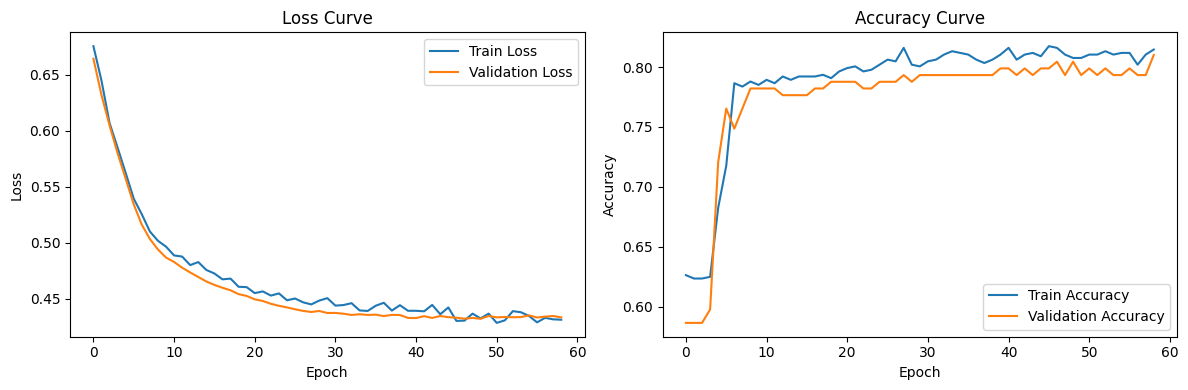

In [ ]:
# 5. 결과 시각화 및 통계 분석

# 학습 곡선 시각화 (loss, accuracy)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

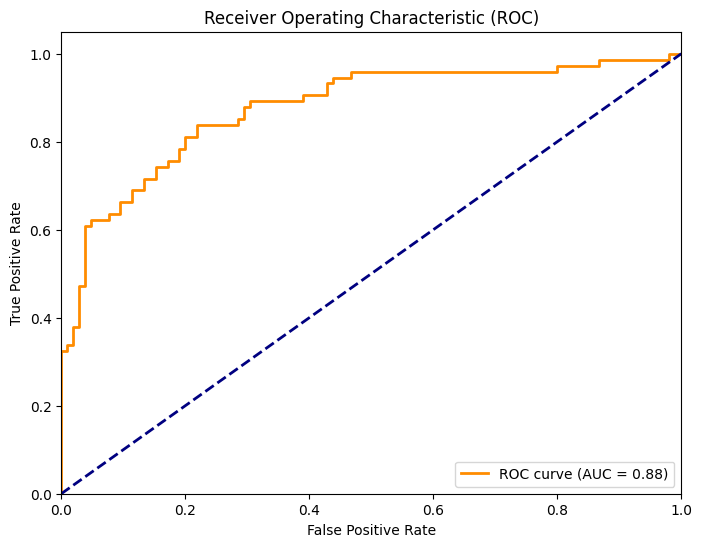

In [ ]:
# ROC Curve 시각화 (Validation set)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

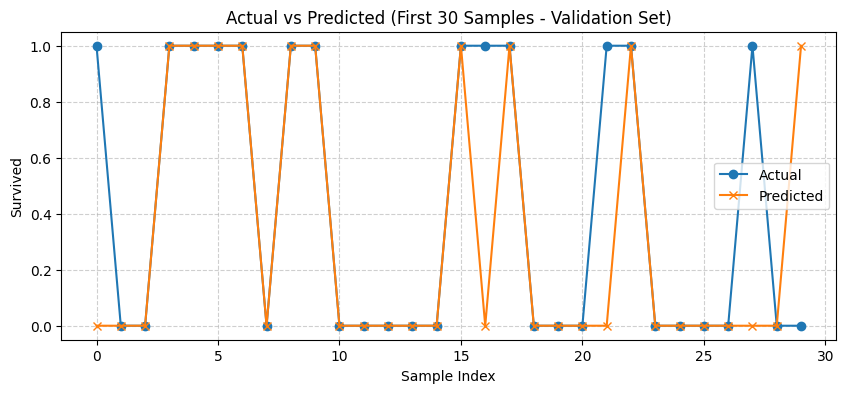

In [ ]:
# 실제값 vs 예측값 시각화 (Validation set - 처음 30개 샘플)
plt.figure(figsize=(10, 4))
plt.plot(y_val[:30].values, label='Actual', marker='o')
plt.plot(y_pred_val[:30].flatten(), label='Predicted', marker='x')  # flatten() 추가
plt.title('Actual vs Predicted (First 30 Samples - Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Survived')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)  # 그리드 추가
plt.show()

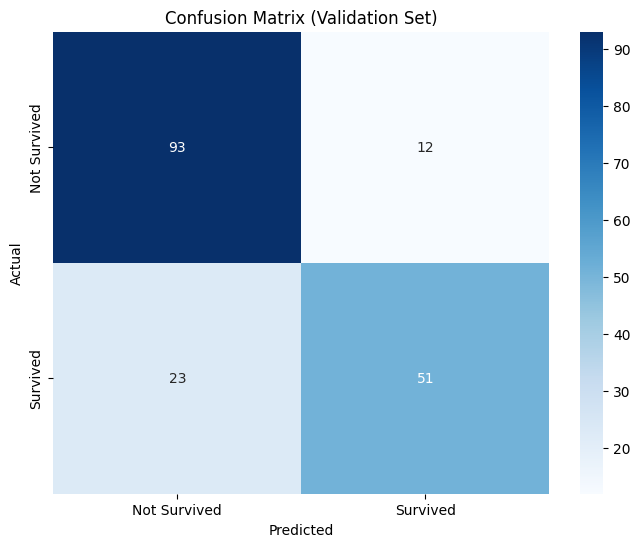

In [ ]:
# Confusion Matrix 시각화 (Validation set)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

In [ ]:
# 6. 예측 결과 저장 (개선된 버전)
# test_titanic.csv에서 직접 PassengerId 가져오기
original_test_df = pd.read_csv("dataset/test_titanic.csv")
passenger_ids = original_test_df['PassengerId']

In [ ]:
# 6. 예측 결과 저장 (개선된 버전)
# test_titanic.csv에서 직접 PassengerId 가져오기
original_test_df = pd.read_csv("dataset/test_titanic.csv")
passenger_ids = original_test_df['PassengerId']

In [ ]:
# 예측 결과와 PassengerId를 합쳐 새로운 DataFrame 생성
forecast_results = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': y_pred.flatten()  # flatten()으로 1차원 배열로 변환
})

In [ ]:
# 결과 확인
print("예측 결과 (처음 5개 샘플):")
print(forecast_results.head())

예측 결과 (처음 5개 샘플):
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0


In [ ]:
# 결과를 CSV 파일로 저장
forecast_results.to_csv('dataset/forecast_titanic.csv', index=False)
print("Survived 예측 결과가 dataset/forecast_titanic.csv 파일로 저장되었습니다.")

Survived 예측 결과가 dataset/forecast_titanic.csv 파일로 저장되었습니다.


In [ ]:
# 7. 모델 저장 (선택 사항)
model.save('model/titanic_lstm_model.h5')
print("모델이 'titanic_lstm_model.h5' 파일로 저장되었습니다.")

모델이 'titanic_lstm_model.h5' 파일로 저장되었습니다.


#### 타이타닉 생존자 예측 탐색적 데이터 분석 EDA (Exploratory Data Analysis)

In [ ]:
# 원본 데이터를 로드
train_df_viz = pd.read_csv("dataset/train_titanic.csv")

In [ ]:
# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format

<ipython-input-42-7b83e7b67e37>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=train_df_viz, palette='viridis')


Text(0, 0.5, '인원 수')

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) mi

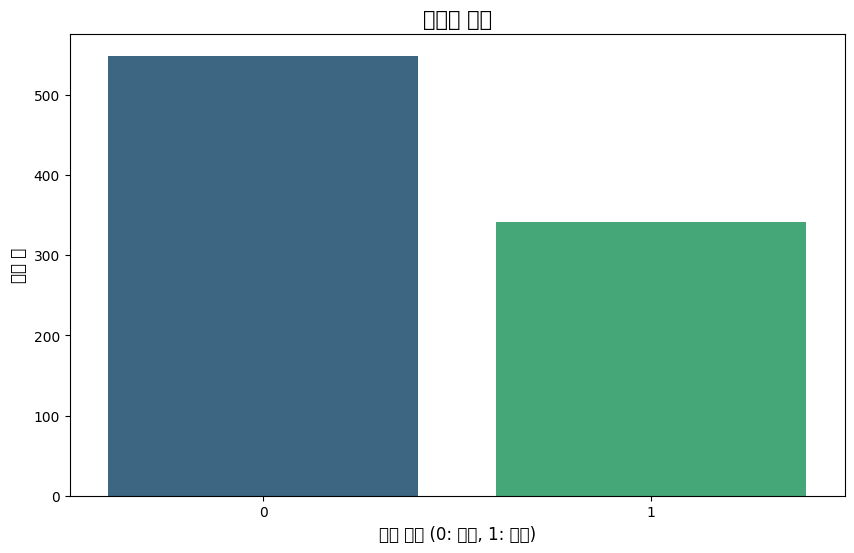

In [ ]:
# 생존자 분포 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='Survived', data=train_df_viz, palette='viridis')
plt.title('생존자 분포', fontsize=15)
plt.xlabel('생존 여부 (0: 사망, 1: 생존)', fontsize=12)
plt.ylabel('인원 수', fontsize=12)

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) m

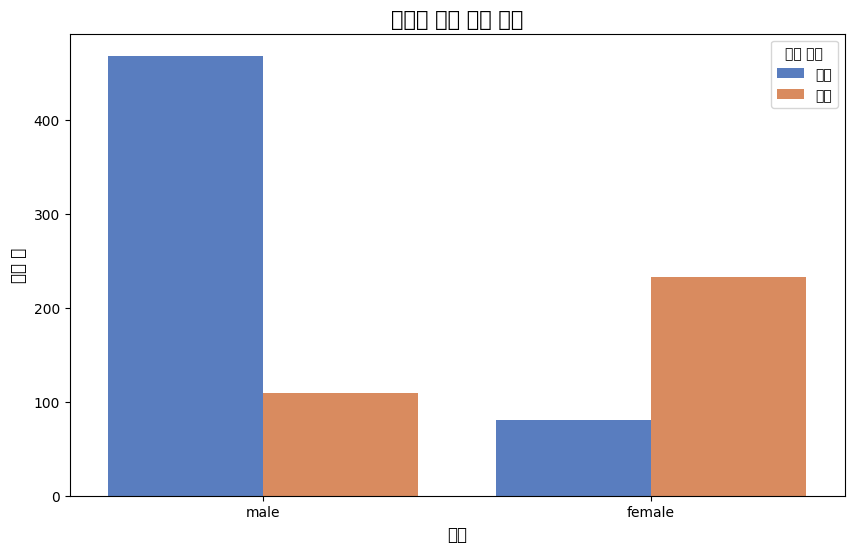

In [ ]:
# 성별과 생존 관계
plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', hue='Survived', data=train_df_viz, palette='muted')
plt.title('성별에 따른 생존 여부', fontsize=15)
plt.xlabel('성별', fontsize=12)
plt.ylabel('인원 수', fontsize=12)
plt.legend(title='생존 여부', labels=['사망', '생존'])

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/u

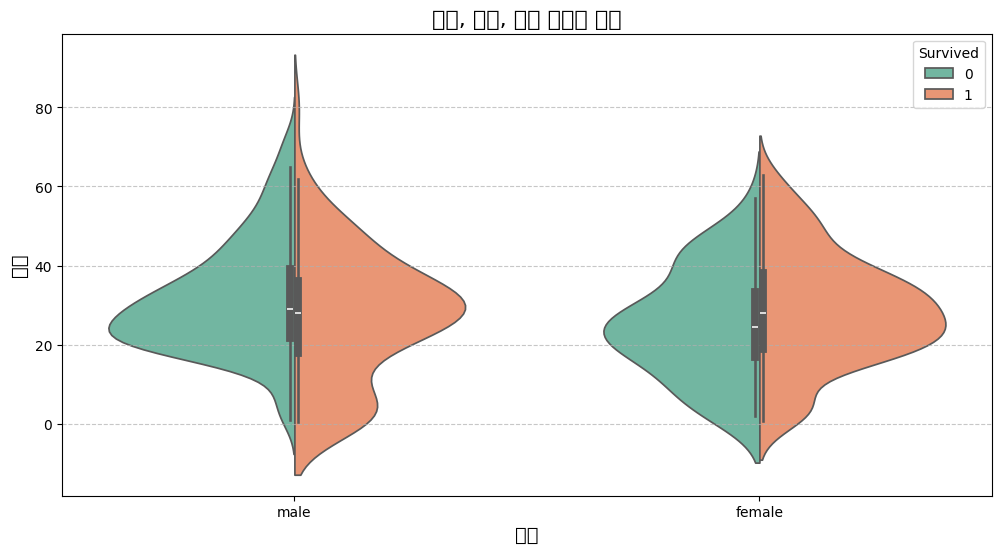

In [ ]:
# 나이, 성별, 생존 관계를 보여주는 바이올린 플롯
plt.figure(figsize=(12, 6))
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train_df_viz.dropna(subset=['Age']),
               split=True, palette='Set2')
plt.title('성별, 나이, 생존 여부의 관계', fontsize=16)
plt.xlabel('성별', fontsize=14)
plt.ylabel('나이', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Figure size 1200x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

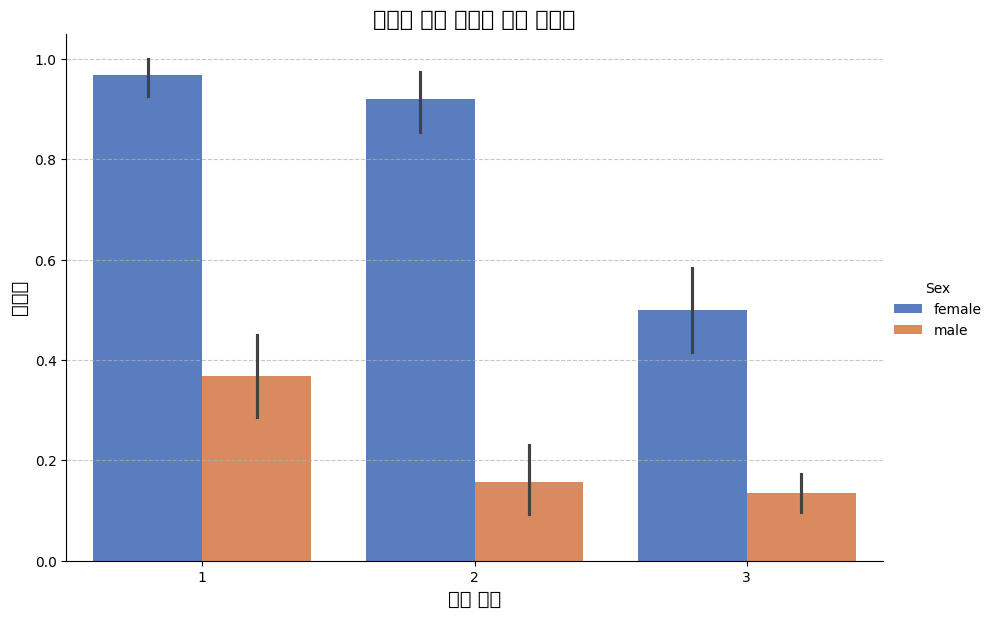

In [ ]:
# 성별과 객실 등급에 따른 생존율 (인터랙션 효과) , 검은색 선은 오차
plt.figure(figsize=(12, 6))
sns.catplot(x='Pclass', y='Survived', hue='Sex', kind='bar', data=train_df_viz, height=6, aspect=1.5, palette='muted')
plt.title('성별과 객실 등급에 따른 생존율', fontsize=16)
plt.xlabel('객실 등급', fontsize=14)
plt.ylabel('생존율', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<ipython-input-46-69fccb2aa8b1>:10: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-69fccb2aa8b1>:10: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-69fccb2aa8b1>:10: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-69fccb2aa8b1>:10: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-69fccb2aa8b1>:10: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-69fccb2aa8b1>:10: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-69fccb2aa8b1>:10: UserWarning: Glyph 55176 (\N{HANGUL SYLLABLE HI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipy

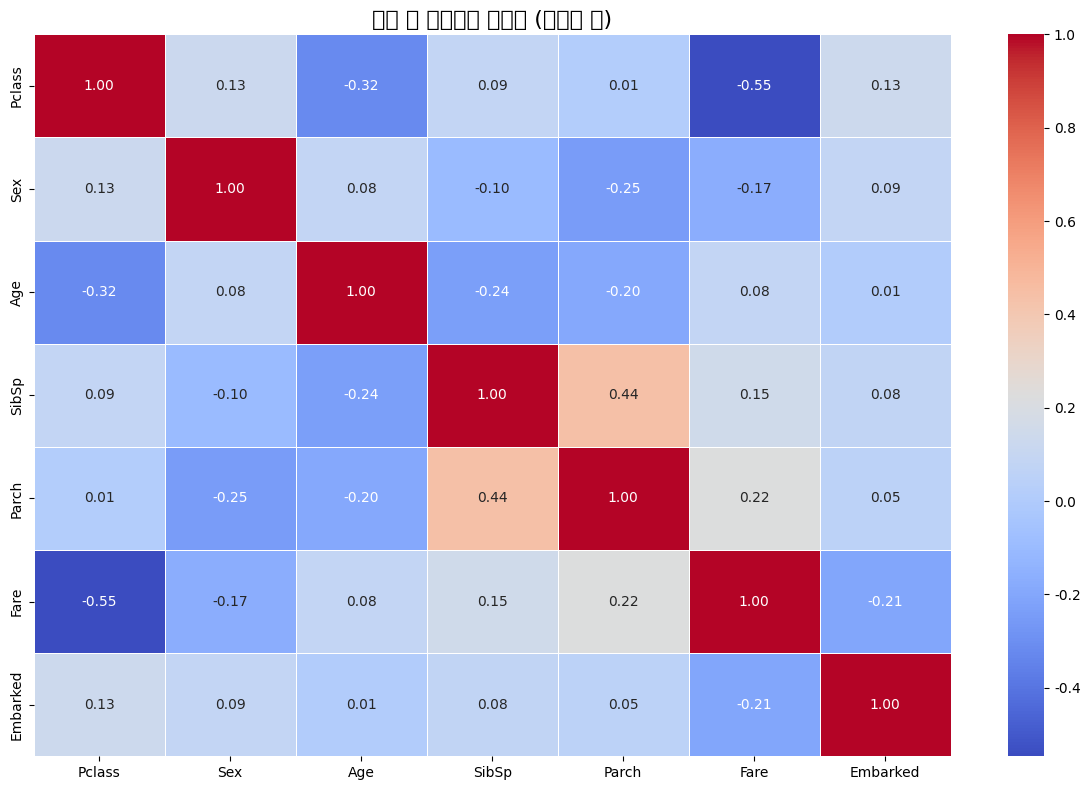

In [ ]:
# 히트맵으로 변수 간 상관관계 확인 (전처리된 데이터 사용)
plt.figure(figsize=(12, 8))
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[2]), columns=train_df.drop('Survived', axis=1).columns)

# 상관계수 행렬 계산
corr_matrix = X_train_df.corr()
# 히트맵 그리기
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('변수 간 상관관계 히트맵 (전처리 후)', fontsize=16)
plt.tight_layout()
plt.show()

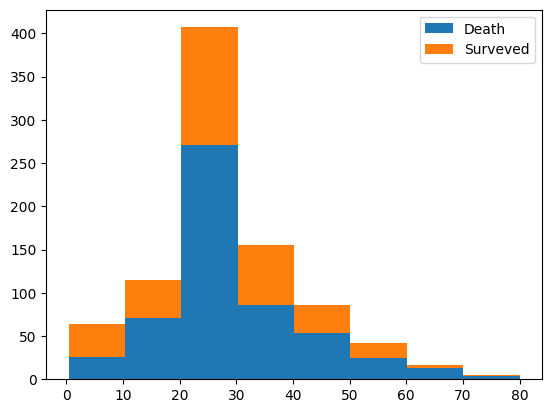

In [ ]:
# 연령별 생존률
plt.hist(x=[train_df.Age[train_df.Survived==0], train_df.Age[train_df.Survived==1]], bins=8, histtype='barstacked', label=['Death', 'Surveved'])
plt.legend()

특성 이름: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X_sample 형태: (100, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

SHAP 값 형태: (100, 7)
특성별 중요도: [0.118959   0.246174   0.02392127 0.01993277 0.00753165 0.01368064
 0.02374917]


<ipython-input-48-62ec4886396a>:33: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-62ec4886396a>:33: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-62ec4886396a>:33: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-62ec4886396a>:33: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-62ec4886396a>:33: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyp

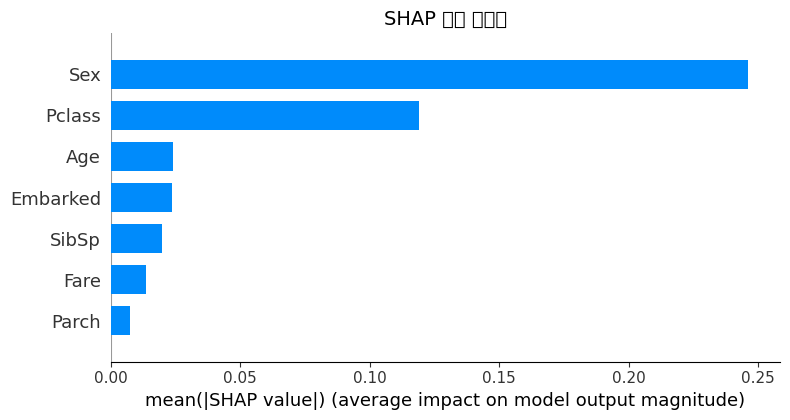

<ipython-input-48-62ec4886396a>:41: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-62ec4886396a>:41: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-62ec4886396a>:41: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-62ec4886396a>:41: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-62ec4886396a>:41: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-62ec4886396a>:41: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font

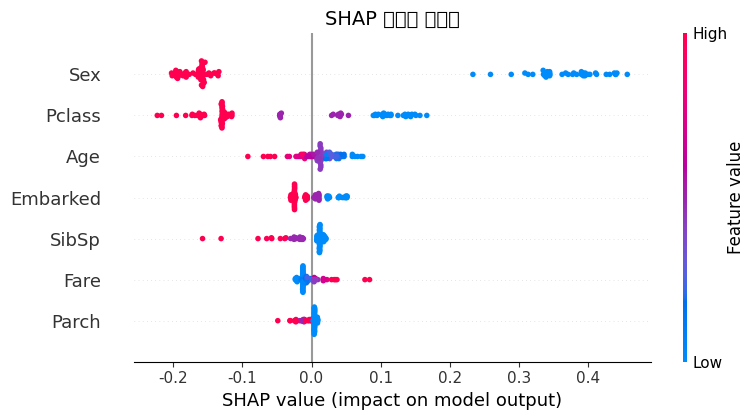

<ipython-input-48-62ec4886396a>:58: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-62ec4886396a>:58: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-62ec4886396a>:58: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-62ec4886396a>:58: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-62ec4886396a>:58: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-62ec4886396a>:58: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-48-62ec4886396a>:58: UserWarning: Glyph 47215 (\N{HANGUL SYLLABLE ROS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


상위 3개 중요 특성: ['Sex', 'Pclass', 'Age']


<Figure size 1000x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47215 (\N{HANGUL SYLLABLE ROS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


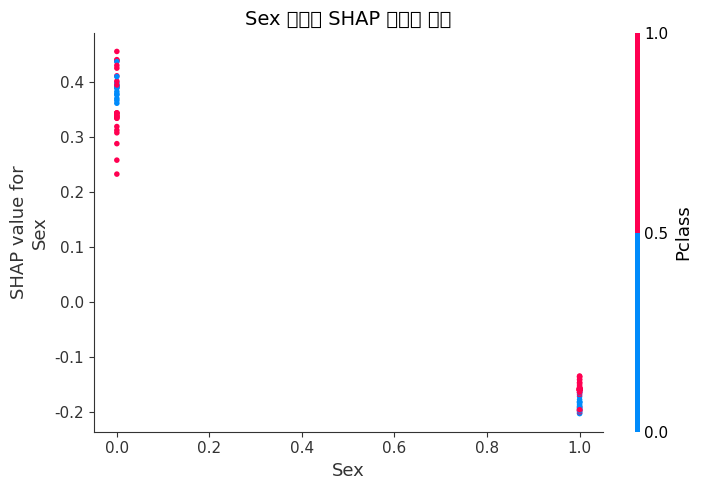

<Figure size 1000x600 with 0 Axes>

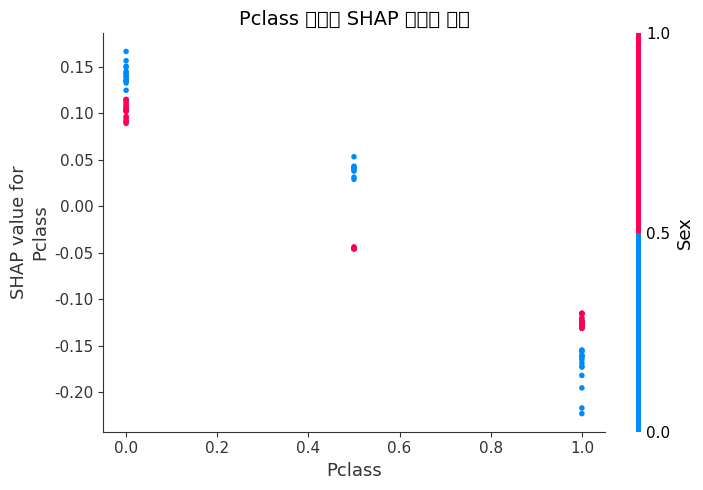

<Figure size 1000x600 with 0 Axes>

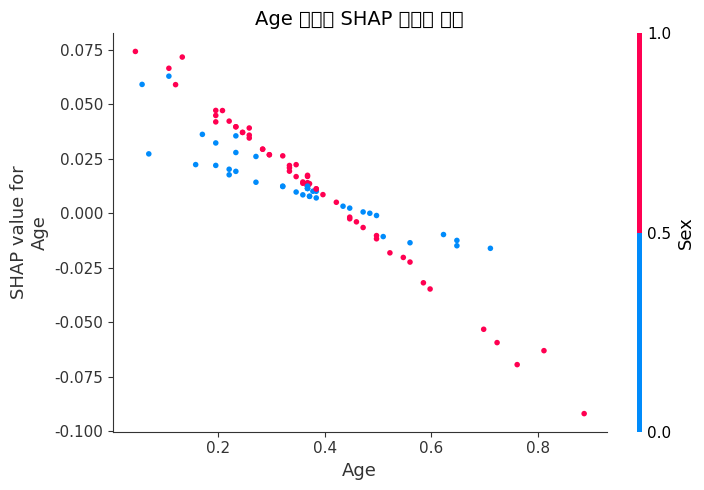

In [ ]:
# SHAP 분석을 위한 함수 정의
def f(X):
    # SHAP은 원본 입력 형태를 요구하므로 LSTM 입력 형태로 변환
    X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])
    return model.predict(X_reshaped).flatten()  # flatten()을 추가해 1차원 배열로 변환

# 원본 형태의 데이터로 SHAP 분석 준비 (시각화용 샘플 제한)
X_sample = X_val.reshape(X_val.shape[0], X_val.shape[2])
X_sample = X_sample[:100]  # 계산 시간 단축을 위해 100개 샘플만 사용

# 백그라운드 데이터 생성
background = shap.sample(X_sample, 10)  # 10개의 배경 데이터 샘플링

# 특성 이름 확인 (디버깅용)
print("특성 이름:", feature_names)
print("X_sample 형태:", X_sample.shape)

# SHAP 값 계산 (KernelExplainer 사용)
explainer = shap.KernelExplainer(f, background)
shap_values = explainer.shap_values(X_sample)

# 모든 특성을 강제로 표시하기 위한 설정
max_display = len(feature_names)  # 모든 특성 표시
print("SHAP 값 형태:", np.array(shap_values).shape)
print("특성별 중요도:", np.abs(shap_values).mean(0))

# Title이 포함된 그래프 생성 방식 수정
# 중요도 막대 그래프
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names,
                 plot_type="bar", show=False, max_display=max_display)
plt.title("SHAP 변수 중요도", fontsize=14)
plt.tight_layout()
plt.show()

# 변수별 영향도
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names,
                 show=False, max_display=max_display)
plt.title("SHAP 변수별 영향도", fontsize=14)
plt.tight_layout()
plt.show()

# 개별 변수 의존성 플롯 (상위 3개만)
# 중요도 순으로 특성 인덱스 정렬
importance = np.abs(shap_values).mean(0)
sorted_idx = np.argsort(-importance)
top_features = [feature_names[i] for i in sorted_idx[:3]]  # 상위 3개 특성

print("상위 3개 중요 특성:", top_features)

# 상위 특성에 대해서만 의존성 플롯 생성
for idx in sorted_idx[:3]:
    feature = feature_names[idx]
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(idx, shap_values, X_sample, feature_names=feature_names, show=False)
    plt.title(f"{feature} 변수의 SHAP 의존성 플롯", fontsize=14)
    plt.tight_layout()
    plt.show()

### 비지도학습 클러스터링 예제(k-means)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
dataset = pd.read_csv('./dataset/KMeansData.csv')
dataset[:5]

,hour,score
0,7.33,73
1,3.71,55
2,3.43,55
3,3.06,89
4,3.33,79


In [ ]:
X = dataset.iloc[:,:].values
X[:5]

array([[ 7.33, 73.  ],
       [ 3.71, 55.  ],
       [ 3.43, 55.  ],
       [ 3.06, 89.  ],
       [ 3.33, 79.  ]])

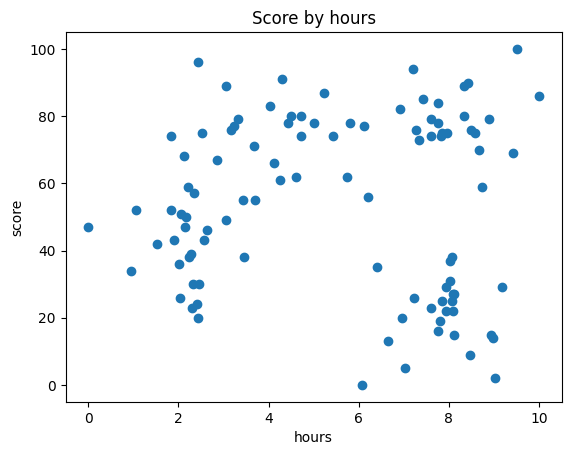

In [ ]:
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

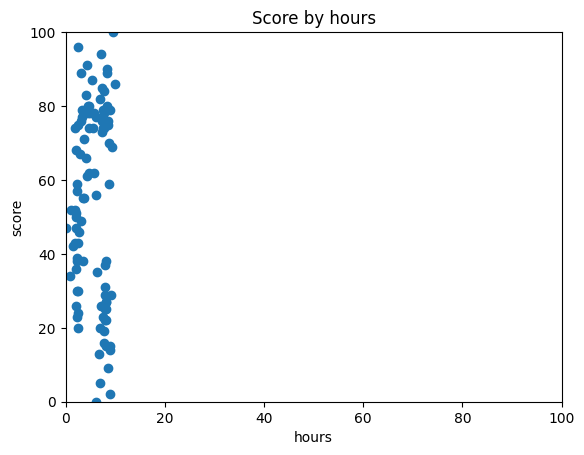

In [ ]:
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('hours')
plt.xlim(0, 100)
plt.ylabel('score')
plt.ylim(0, 100)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X[:5]

array([[ 0.68729921,  0.73538376],
       [-0.66687438,  0.04198891],
       [-0.77161709,  0.04198891],
       [-0.9100271 ,  1.35173473],
       [-0.8090252 ,  0.96651537]])

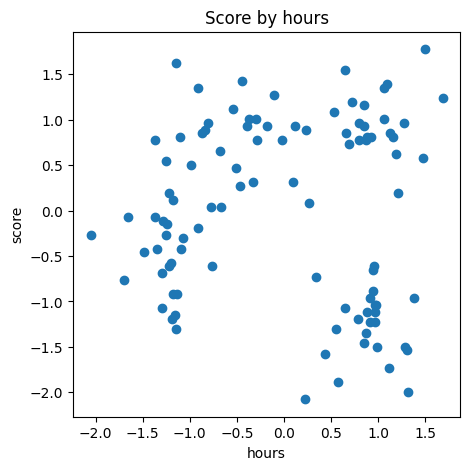

In [ ]:
plt.figure(figsize =(5, 5))
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

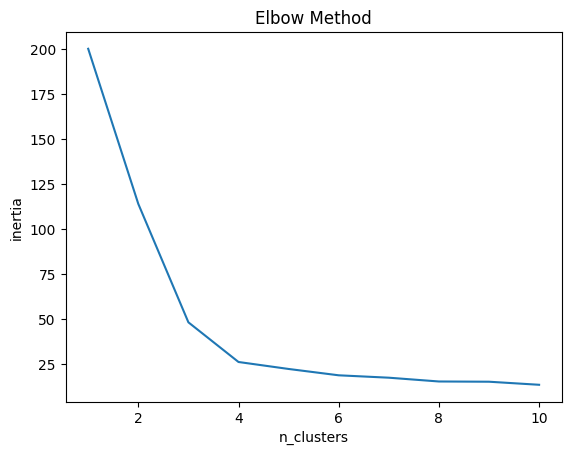

In [ ]:
from sklearn.cluster import KMeans
inertia_list = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia_list)
plt.title('Elbow Method')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.show()

In [ ]:
K=4
kmeans = KMeans(n_clusters=K, random_state=0)
y_kmeans = kmeans.fit_predict(X)

In [ ]:
y_kmeans

array([1, 0, 3, 0, 0, 2, 2, 0, 1, 0, 0, 3, 2, 3, 3, 0, 2, 1, 3, 0, 2, 0,
       3, 2, 1, 1, 3, 3, 3, 3, 2, 2, 3, 0, 1, 1, 3, 0, 0, 0, 3, 2, 1, 3,
       3, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 0, 0, 3, 2, 2, 1, 1, 1, 1, 2,
       2, 0, 2, 1, 3, 1, 1, 1, 3, 3, 3, 3, 0, 1, 2, 1, 2, 2, 1, 0, 3, 2,
       1, 3, 0, 2, 0, 1, 3, 0, 1, 0, 2, 3], dtype=int32)

In [ ]:
centers = kmeans.cluster_centers_
centers

array([[-0.54299598,  0.79316666],
       [ 0.96910697,  0.97133061],
       [ 0.8837666 , -1.26929779],
       [-1.24939347, -0.48807293]])

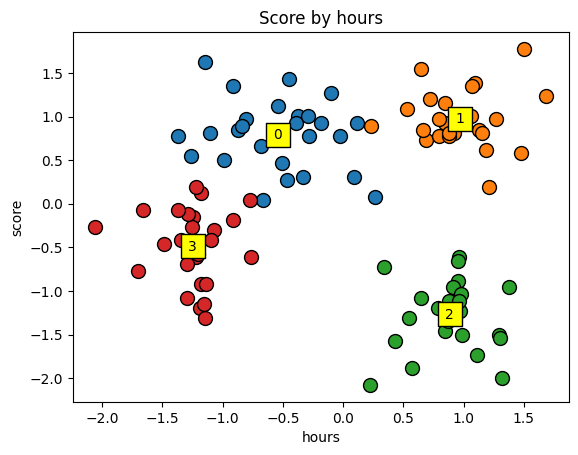

In [ ]:
for cluster in range(K):
    plt.scatter(X[y_kmeans == cluster, 0], X[y_kmeans == cluster, 1], s=100, edgecolor='black')
    plt.scatter(centers[cluster, 0], centers[cluster, 1], s=300, edgecolor='black', color='yellow', marker='s')
    plt.text(centers[cluster, 0], centers[cluster, 1], cluster, va='center', ha='center')

plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

In [ ]:
X_org = sc.inverse_transform(X)
X_org[:5]

array([[ 7.33, 73.  ],
       [ 3.71, 55.  ],
       [ 3.43, 55.  ],
       [ 3.06, 89.  ],
       [ 3.33, 79.  ]])

In [ ]:
centers_org = sc.inverse_transform(centers)
centers_org

array([[ 4.04115385, 74.5       ],
       [ 8.08333333, 79.125     ],
       [ 7.8552    , 20.96      ],
       [ 2.1528    , 41.24      ]])

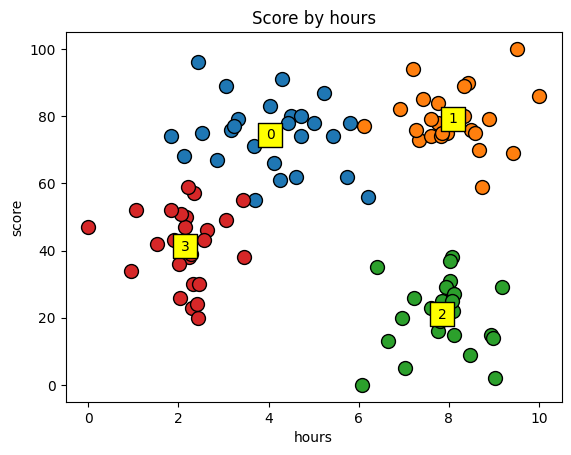

In [ ]:
for cluster in range(K):
    plt.scatter(X_org[y_kmeans == cluster, 0], X_org[y_kmeans == cluster, 1], s=100, edgecolor='black')
    plt.scatter(centers_org[cluster, 0], centers_org[cluster, 1], s=300, edgecolor='black', color='yellow', marker='s')
    plt.text(centers_org[cluster, 0], centers_org[cluster, 1], cluster, va='center', ha='center')

plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

### 비지도학습(센서기반)

In [ ]:
# 온도, 압력, 진동 센서 데이터를 활용한 비지도 학습 기반 이상 탐지 (오토인코더 기반)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Matplotlib에서 3차원 플롯을 그릴 수 있도록 지원하는 도구

In [ ]:
# 1. 데이터 불러오기
try:
    df_train = pd.read_csv("dataset/train_data.csv")
    df_test = pd.read_csv("dataset/test_data.csv")
except FileNotFoundError:
    print("지정된 경로에 파일이 존재하지 않습니다.")
    exit()

In [ ]:
# 2. 데이터 전처리
# 결측치 확인 및 처리
if df_train.isnull().sum().any() or df_test.isnull().sum().any():  # any() 결측치가 있으면 True, False로 반환
    print("경고: 결측치가 감지되었습니다. 평균값으로 채웁니다.")
    df_train.fillna(df_train.mean(), inplace=True)
    df_test.fillna(df_test.mean(), inplace=True)

# 피처 선택
X_train = df_train[["temperature", "pressure", "vibration"]].values
X_test = df_test[["temperature", "pressure", "vibration"]].values
y_test = df_test["label"].values  # 0 = 정상, 1 = 불량

# 데이터 스케일링 (StandardScaler 사용)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 3. 오토인코더 모델 정의
def build_autoencoder(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        # 인코더
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        # 디코더
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(input_dim, activation=None)
    ])
    return model

# 모델 생성 및 컴파일
autoencoder = build_autoencoder(input_dim=3)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

In [ ]:
# 4. 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# 5. 모델 학습
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.0180 - val_loss: 0.7551
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8212 - val_loss: 0.4234
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4756 - val_loss: 0.2262
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3334 - val_loss: 0.0750
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2283 - val_loss: 0.0413
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2109 - val_loss: 0.0374
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1884 - val_loss: 0.0265
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1612 - val_loss: 0.0225
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1516 - val_loss: 0.0302
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1444 - val_loss: 0.0249
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1623 - val_loss: 0.0251
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

In [ ]:
# 6. 테스트셋에 대한 재구성 오차 계산
X_test_pred = autoencoder.predict(X_test_scaled, verbose=0)
mse = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

In [ ]:
# 7. 임계값 설정 (기존: 95% 백분위)
threshold_percentile = 95   # mse 값 중에서 하위 95% (정상), 상위 5%(불량)
threshold = np.percentile(mse, threshold_percentile)
print(f"Threshold ({threshold_percentile}% percentile): {threshold:.4f}")

Threshold (95% percentile): 6.8052


In [ ]:
# 8. 이상 탐지 결과 (기존 임계값 사용)
y_pred = (mse > threshold).astype(int)


 Classification Report (Threshold based on 95% percentile):
              precision    recall  f1-score   support

      Normal       0.70      1.00      0.83       100
     Anomaly       1.00      0.16      0.28        50

    accuracy                           0.72       150
   macro avg       0.85      0.58      0.55       150
weighted avg       0.80      0.72      0.64       150

 Confusion Matrix (Threshold based on 95% percentile):


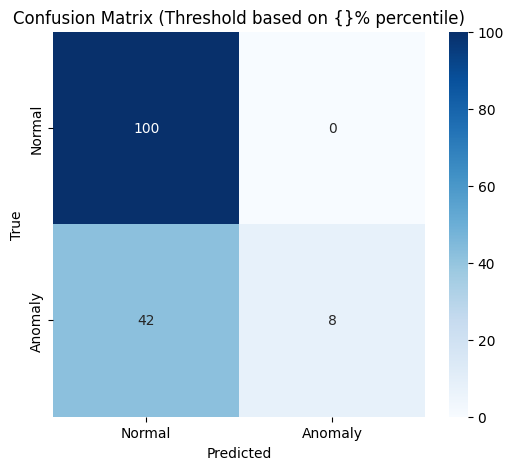

 ROC AUC Score (Threshold based on 95% percentile): 1.0000


In [ ]:
# 9. 평가 (기존 임계값)
print("\n Classification Report (Threshold based on {}% percentile):".format(threshold_percentile))
print(classification_report(y_test, y_pred, target_names=["Normal", "Anomaly"]))  # Normal(정상), Anomaly(불량)

print(" Confusion Matrix (Threshold based on {}% percentile):".format(threshold_percentile))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix (Threshold based on {}% percentile)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

roc_auc = roc_auc_score(y_test, mse)
print(f" ROC AUC Score (Threshold based on {threshold_percentile}% percentile): {roc_auc:.4f}")

In [ ]:
# --- 최적 임계값 찾기 (F1 Score 기반) ---
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, mse)  #  이상 탐지 모델의 성능을 다양한 임계값에서 평가하기 위해 사용
f1_scores = 2 * recalls * precisions / (recalls + precisions + 1e-8)  # fl_scores 공식
best_threshold_idx = np.argmax(f1_scores) # f1_scores 배열에서 가장 큰 값의 인덱스(위치)를 찾아냄
best_threshold = thresholds_pr[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"\nBest Threshold (based on F1 score): {best_threshold:.4f}")
print(f"Best F1 Score: {best_f1:.4f}")


Best Threshold (based on F1 score): 1.5942
Best F1 Score: 1.0000



 Classification Report (Optimized Threshold based on F1 Score):
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       100
     Anomaly       1.00      0.98      0.99        50

    accuracy                           0.99       150
   macro avg       1.00      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

 Confusion Matrix (Optimized Threshold based on F1 Score):


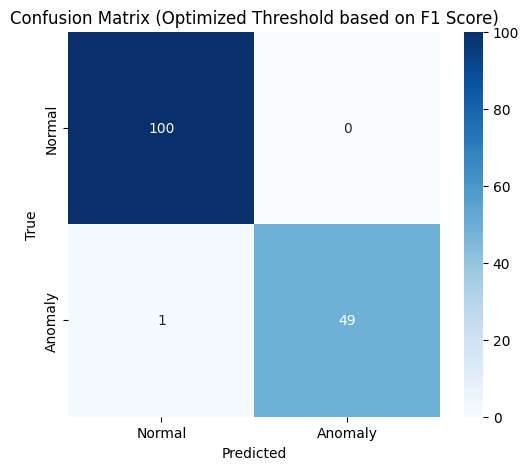

 ROC AUC Score (Optimized Threshold): 1.0000


In [ ]:
# 최적 임계값으로 예측
y_pred_optimized = (mse > best_threshold).astype(int)
print("\n Classification Report (Optimized Threshold based on F1 Score):")
print(classification_report(y_test, y_pred_optimized, target_names=["Normal", "Anomaly"]))

print(" Confusion Matrix (Optimized Threshold based on F1 Score):")
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix (Optimized Threshold based on F1 Score)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

roc_auc_optimized = roc_auc_score(y_test, mse) # MSE 기반 ROC AUC는 임계값 변경에 영향 없음
print(f" ROC AUC Score (Optimized Threshold): {roc_auc_optimized:.4f}")

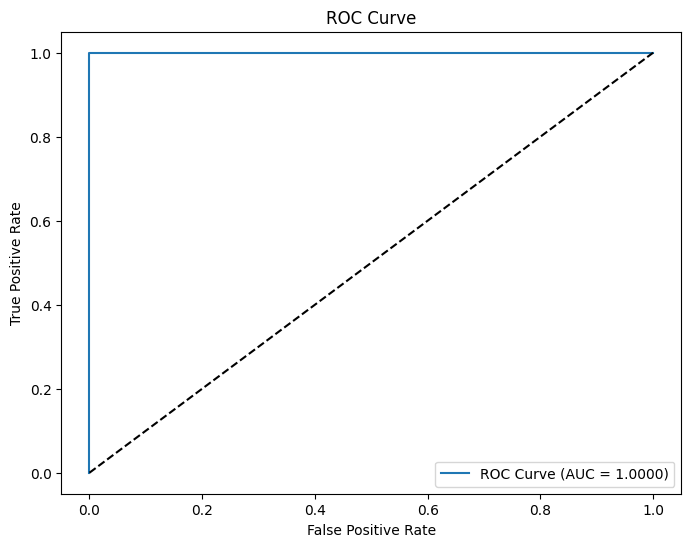

In [ ]:
# 10. ROC 커브 시각화
fpr, tpr, _ = roc_curve(y_test, mse)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

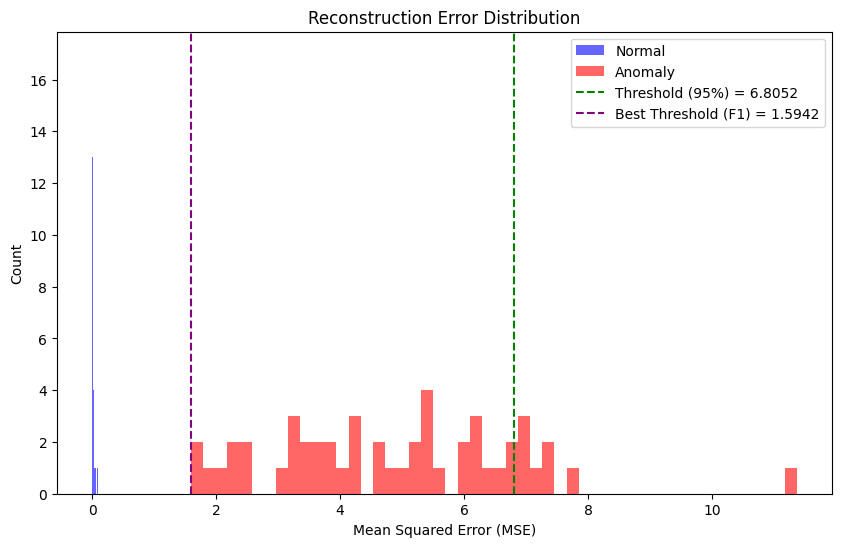

In [ ]:
# 11. 시각화: 재구성 오차 분포
plt.figure(figsize=(10, 6))
plt.hist(mse[y_test == 0], bins=50, alpha=0.6, label="Normal", color='blue')
plt.hist(mse[y_test == 1], bins=50, alpha=0.6, label="Anomaly", color='red')
plt.axvline(threshold, color='green', linestyle='--', label=f'Threshold ({threshold_percentile}%) = {threshold:.4f}')
plt.axvline(best_threshold, color='purple', linestyle='--', label=f'Best Threshold (F1) = {best_threshold:.4f}')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Count")
plt.legend()
plt.show()

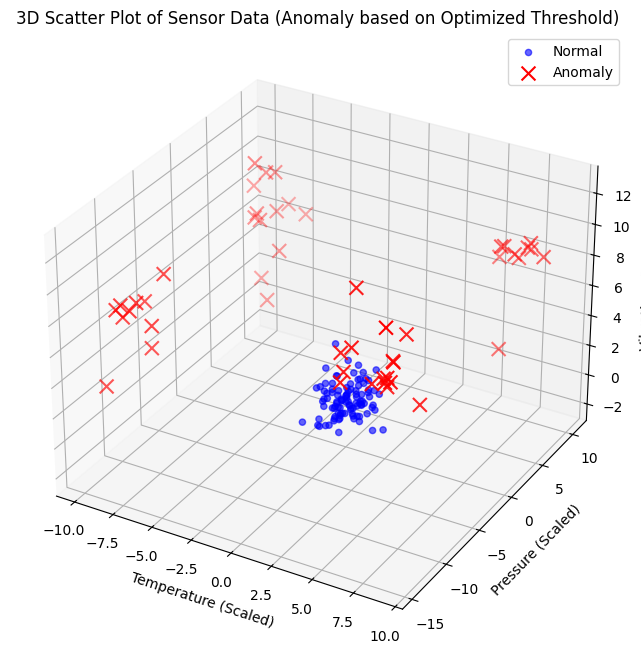

In [ ]:
# 12. 시각화: 3D 산점도
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test_scaled[y_test == 0, 0], X_test_scaled[y_test == 0, 1], X_test_scaled[y_test == 0, 2],
           c='blue', label='Normal', alpha=0.6)
ax.scatter(X_test_scaled[y_pred_optimized == 1, 0], X_test_scaled[y_pred_optimized == 1, 1], X_test_scaled[y_pred_optimized == 1, 2],
           c='red', label='Anomaly', marker='x', s=100)
ax.set_xlabel("Temperature (Scaled)")
ax.set_ylabel("Pressure (Scaled)")
ax.set_zlabel("Vibration (Scaled)")
plt.title("3D Scatter Plot of Sensor Data (Anomaly based on Optimized Threshold)")
plt.legend()
plt.show()

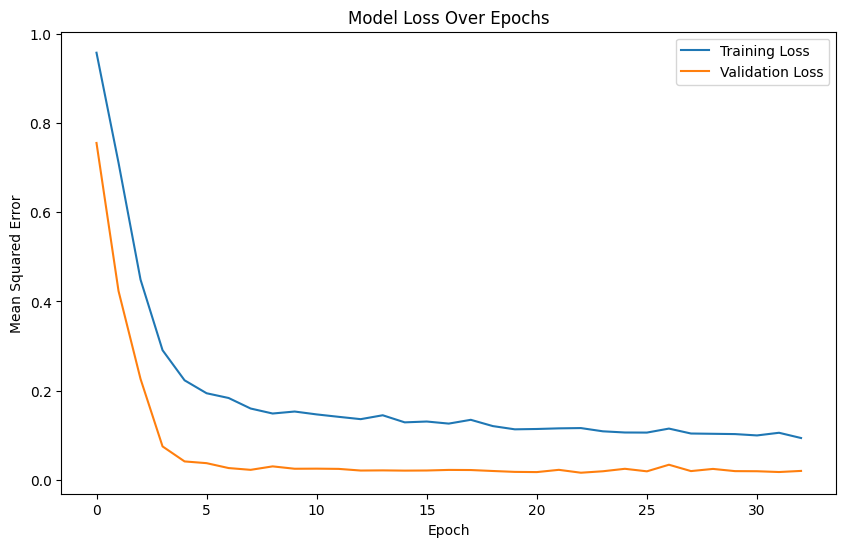

In [ ]:
# 13. 학습 손실 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

In [ ]:
# 14. 단일 테스트 데이터 예측
# 예시 데이터: 온도=25.0, 압력=100.0, 진동=0.5
# 필요 시 아래 값을 원하는 데이터로 변경하세요
test_sample = np.array([[25.0, 100.0, 0.5]])
test_sample_scaled = scaler.transform(test_sample)
test_sample_pred = autoencoder.predict(test_sample_scaled, verbose=0)
test_sample_mse = np.mean(np.square(test_sample_scaled - test_sample_pred))
is_anomaly = test_sample_mse > best_threshold # 최적 임계값 사용
print("\n🔍 단일 데이터 예측 결과 (Optimized Threshold):")
print(f"입력 데이터: 온도={test_sample[0, 0]}, 압력={test_sample[0, 1]}, 진동={test_sample[0, 2]}")
print(f"재구성 오차 (MSE): {test_sample_mse:.4f}")
print(f"결과: {'불량 (Anomaly)' if is_anomaly else '정상 (Normal)'}")


🔍 단일 데이터 예측 결과 (Optimized Threshold):
입력 데이터: 온도=25.0, 압력=100.0, 진동=0.5
재구성 오차 (MSE): 0.4986
결과: 정상 (Normal)
